# Climate Exposure Dataset

- Contains information on climate exposure variables: temperature, humidity, smoke PM and wind speed
- Contains information on population counts and population density
- Cover the year 2020
- Spatial coverage: California (census tract)

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import Polygon

In [4]:
# wind data comes from: https://www.ncei.noaa.gov/access/monitoring/wind/
windu = xr.open_dataset("data/uwnd.10m.gauss.2020.nc")
windv = xr.open_dataset("data/vwnd.10m.gauss.2020.nc")

In [5]:
# Calculate the absolute wind speed
abs_wind_speed = np.sqrt(windu.uwnd**2 + windv.vwnd**2)
tmp_abs_wind = abs_wind_speed.to_dataframe(name="wnd")
tmp_abs_wind = tmp_abs_wind.reset_index()

In [6]:
tmp_abs_wind['lon'] = ((tmp_abs_wind['lon'] + 180) % 360) - 180

In [9]:
# Create a square polygon from lon and lat
def create_square(lon, lat, resolution):
    return Polygon(
        [
            (lon, lat),
            (lon + resolution, lat),
            (lon + resolution, lat + resolution),
            (lon, lat + resolution),
        ]
    )

In [10]:
# Apply the function to every row in the DataFrame
tmp_abs_wind["geometry"] = tmp_abs_wind.apply(
    lambda row: create_square(row["lon"], row["lat"], 1.9), axis=1
)

In [11]:
gdf = gpd.GeoDataFrame(tmp_abs_wind, geometry="geometry")

In [12]:
wind_gdf = gdf

In [13]:
gdf = gpd.read_file("shapefiles/tl_2020_06_tract/tl_2020_06_tract.shp")

In [14]:
wind_gdf = wind_gdf.set_crs(gdf.crs)

In [15]:
len(wind_gdf)

6605568

In [16]:
joined_data = gpd.sjoin(gdf, wind_gdf, how="inner", predicate="intersects")

In [18]:
len(joined_data)

3539952

In [19]:
aggregated_data = joined_data.groupby(by=["time", "GEOID"])["wnd"].mean().reset_index()

In [20]:
len(aggregated_data)

3341214

In [21]:
# Merge aggregated data back to tract data
merged_data = gdf.merge(aggregated_data, on="GEOID")

<AxesSubplot: >

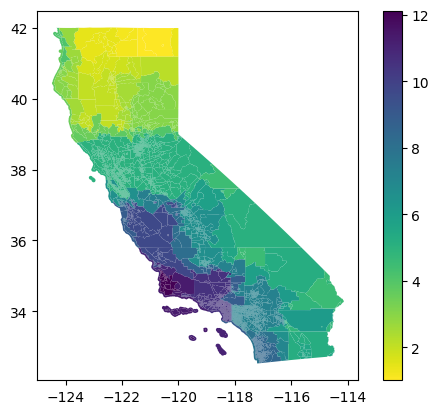

In [22]:
merged_data[merged_data["time"] == "2020-05-01"].plot(
    column="wnd", legend=True, linewidth=0, cmap="viridis_r"
)

In [28]:
# temp data is from https://prism.oregonstate.edu
df = pd.read_parquet("data/esri_tmin_tmax_pm25_merged.parquet")

In [29]:
df.head()

tmax      tmin      pm25
time       FIPS                                 
2005-12-31 1765.0  13.350000  7.850000  4.986000
           1766.0  14.950006  8.249994  5.500000
           1767.0  14.950006  8.249994  5.486667
           1768.0  14.950006  8.249994  5.437778
           1769.0  14.950006  8.249994  5.480000

In [30]:
rhum = xr.open_dataset("data/esri/RelHum_2006_2021_Cali.nc")

In [31]:
rhum = rhum[["FIPS", "RELATIVE_HUMIDITY_NONE_SPATIAL_NEIGHBORS"]].to_dataframe()
rhum = rhum.drop(columns=["lat", "lon"])
rhum = rhum.groupby(["time", "FIPS"]).first()

df_ = df.join(rhum, rsuffix="_rhum")
df_ = df_.rename(columns={"RELATIVE_HUMIDITY_NONE_SPATIAL_NEIGHBORS": "rhum"})

In [33]:
df = df_.reset_index()

In [34]:
df.head()

,time,FIPS,tmax,tmin,pm25,rhum
0,2005-12-31,1765.0,13.350000,7.850000,4.986000,88.400002
1,2005-12-31,1766.0,14.950006,8.249994,5.500000,91.400002
2,2005-12-31,1767.0,14.950006,8.249994,5.486667,91.400002
3,2005-12-31,1768.0,14.950006,8.249994,5.437778,91.400002
4,2005-12-31,1769.0,14.950006,8.249994,5.480000,91.400002


In [35]:
df = df[df["time"].dt.year == 2020]

In [36]:
df = df.drop(columns="pm25")

## Add population count and density

In [37]:
df.FIPS = df.FIPS.astype(int)

In [38]:
gdf = gpd.read_file("data/esri/FIPSMapping.gdb")
gdf["FIPS_1"] = gdf.FIPS_1.astype(int)

In [39]:
df = df.merge(gdf, left_on="FIPS", right_on="FIPS")

In [42]:
pop = pd.read_csv(
    "data/esri/crosswalk/FIPSMapping_gdb_censustract_2020_ca.csv.csv",
    usecols=["FIPS", "POPULATION_2020", "POP20_SQMI"],
)

In [43]:
df = df.merge(pop, left_on="FIPS_1", right_on="FIPS")

In [45]:
df = df.drop(columns=["FIPS_x", "Shape_Length", "Shape_Area", "FIPS_y"])

In [46]:
len(df)

3174318

## Add wildfire smoke PM2.5

In [49]:
# data from https://github.com/echolab-stanford/daily-10km-smokePM
pspm25 = pd.read_csv("data/smoke_pm_2020.csv")

In [50]:
pspm25["date"] = pd.to_datetime(pspm25["date"])

In [52]:
pspm25.head()

,GEOID,smoke_pm,date
0,6001400100,0.0,2020-01-01
1,6001400200,0.0,2020-01-01
2,6001400300,0.0,2020-01-01
3,6001400400,0.0,2020-01-01
4,6001400500,0.0,2020-01-01


In [53]:
df = df.merge(pspm25, right_on=["GEOID", "date"], left_on=["FIPS_1", "time"])

In [55]:
aggregated_data["GEOID_s"] = aggregated_data.GEOID

In [57]:
aggregated_data.GEOID = aggregated_data.GEOID.astype(int)

In [58]:
len(df)

3174318

In [59]:
df = df.merge(aggregated_data, on=["GEOID", "time"])

In [60]:
df["temp"] = (df["tmin"] + df["tmax"]) / 2

In [61]:
df = df.drop(columns=["FIPS_1", "date", "tmin", "tmax"])

In [62]:
df = df[
    [
        "time",
        "GEOID_s",
        "temp",
        "rhum",
        "wnd",
        "smoke_pm",
        "geometry",
        "POPULATION_2020",
        "POP20_SQMI",
    ]
]

In [63]:
df = df.rename(columns={"GEOID_s": "GEOID"})

In [64]:
df = df.drop(columns=["geometry"])

In [65]:
df.columns

Index(['time', 'GEOID', 'temp', 'rhum', 'wnd', 'smoke_pm', 'POPULATION_2020',
       'POP20_SQMI'],
      dtype='object')

## Get avg summer month values

In [66]:
df.head()

,time,GEOID,temp,rhum,wnd,smoke_pm,POPULATION_2020,POP20_SQMI
0,2020-01-01,06001400100,12.100000,88.699997,9.087395,0.0,3038,1133.6
1,2020-01-02,06001400100,11.699991,77.400002,10.237971,0.0,3038,1133.6
2,2020-01-03,06001400100,9.499994,100.000000,1.784081,0.0,3038,1133.6
3,2020-01-04,06001400100,9.499994,93.699997,3.989018,0.0,3038,1133.6
4,2020-01-05,06001400100,9.900003,75.000000,10.107844,0.0,3038,1133.6


In [67]:
df["month"] = df["time"].dt.month


# Function to calculate the monthly averages for each variable
def calculate_monthly_averages(df, variable):
    grouped = df.groupby(["GEOID", "month"])[variable].mean().reset_index()
    pivoted = grouped.pivot_table(index="GEOID", columns="month", values=variable)
    pivoted = pivoted.rename(
        columns={6: "jun", 7: "jul", 8: "aug", 9: "sep", 10: "oct"}
    )
    pivoted = pivoted.drop(columns=[1, 2, 3, 4, 5, 11, 12])
    pivoted.columns = [
        f"avg_{variable}_{month}" for month in ["jun", "jul", "aug", "sep", "oct"]
    ]
    return pivoted

In [68]:
tmin_monthly = calculate_monthly_averages(df, "temp")
tmax_monthly = calculate_monthly_averages(df, "rhum")
rhum_monthly = calculate_monthly_averages(df, "wnd")
smokepm_monthly = calculate_monthly_averages(df, "smoke_pm")

result = pd.concat([tmin_monthly, tmax_monthly, rhum_monthly, smokepm_monthly], axis=1)
result.reset_index(inplace=True)

In [69]:
df = df.groupby("GEOID")["POPULATION_2020", "POP20_SQMI"].first().reset_index()

/var/folders/b_/vlxgm9n10bz569rffzmcc5dc0000gn/T/ipykernel_57806/4001476570.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby("GEOID")["POPULATION_2020","POP20_SQMI"].first().reset_index()


In [70]:
df = df.merge(result, on="GEOID")

In [71]:
df.head()

,GEOID,POPULATION_2020,POP20_SQMI,avg_temp_jun,avg_temp_jul,avg_temp_aug,avg_temp_sep,avg_temp_oct,avg_rhum_jun,avg_rhum_jul,...,avg_wnd_jun,avg_wnd_jul,avg_wnd_aug,avg_wnd_sep,avg_wnd_oct,avg_smoke_pm_jun,avg_smoke_pm_jul,avg_smoke_pm_aug,avg_smoke_pm_sep,avg_smoke_pm_oct
0,06001400100,3038,1133.6,17.950001,17.862903,20.890323,21.330002,20.487098,78.096667,84.36129,...,6.959335,6.010748,5.445568,4.542623,5.984679,0.0,0.133076,6.670296,25.23939,5.944235
1,06001400200,2001,8700.0,17.950000,17.649998,19.579032,21.013331,20.125807,79.640000,84.20000,...,6.959335,6.010748,5.445568,4.542623,5.984679,0.0,0.145010,6.921538,25.34102,6.179484
2,06001400300,5504,12800.0,17.950000,17.649998,19.579032,21.013331,20.125807,79.640000,84.20000,...,6.959335,6.010748,5.445568,4.542623,5.984679,0.0,0.145010,6.921538,25.34102,6.179484
3,06001400400,4112,14685.7,17.950000,17.649998,19.579032,21.013331,20.125807,79.640000,84.20000,...,6.959335,6.010748,5.445568,4.542623,5.984679,0.0,0.145010,6.921538,25.34102,6.179484
4,06001400500,3644,15843.5,17.950000,17.649998,19.579032,21.013331,20.125807,79.640000,84.20000,...,6.959335,6.010748,5.445568,4.542623,5.984679,0.0,0.145010,6.921538,25.34102,6.179484


In [72]:
df.to_csv("../data/climate_exposure_ca_2020.csv", index=False)